# 3.0 - Feature engineering

This notebook focuses on **feature engineering**. The goal is to use the clean, preprocessed data from the previous stage to create new, potentially more informative features using different techniques.

We will explore three main approaches:
1.  **Principal Component Analysis (PCA):** A dimensionality reduction technique to address multicollinearity.
2.  **Ratio features:** Creating new features based on domain knowledge to capture geometric properties like shape and growth.
3.  **Polynomial features:** Automatically generating interaction and higher-order features to capture non-linear relationships.


## 1. Load and preprocess data

As a best practice for reproducibility, we will start by running the complete preprocessing pipeline developed in the previous notebooks. This provides a self-contained environment and gives us the clean, scaled dataset that is the starting point for all our feature engineering experiments.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import custom functions
from model.data_ingestion import load_raw_data
from model.data_preprocessing import drop_unnecessary_columns, map_diagnosis_to_numerical, prepare_features_and_target

# Import necessary tools from scikit-learn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA

# Set plotting styles
sns.set_style('whitegrid')
%matplotlib inline

# Display options for pandas
pd.set_option('display.max_columns', None)


Let's start by running the complete preprocessing pipeline that was developed and tested in `2.0-Data_preprocessing.ipynb`. This will provide us with the clean, scaled dataset that serves as the starting point for our feature engineering work.

In [6]:
# Load Data
df_raw = load_raw_data('../data/data.csv')

# Initial Cleaning & Mapping
df_cleaned = drop_unnecessary_columns(df_raw.copy())
df_mapped = map_diagnosis_to_numerical(df_cleaned.copy())

# We need the original, unscaled features to create meaningful ratios
X_unscaled, y = prepare_features_and_target(df_mapped)

# Initial Feature Selection
features_to_drop = [
    'fractal_dimension_se',
    'smoothness_se',
    'fractal_dimension_mean',
    'texture_se',
    'symmetry_se'
]

X_selected_unscaled = X_unscaled.drop(columns=features_to_drop)

# Feature Scaling
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_selected_unscaled)
X_processed = pd.DataFrame(X_scaled_array, columns=X_selected_unscaled.columns)

print("Data successfully preprocessed.")
print("Shape of baseline processed features (X_processed):", X_processed.shape)
X_processed.head()


Data successfully preprocessed.
Shape of baseline processed features (X_processed): (569, 25)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,radius_se,perimeter_se,area_se,compactness_se,concavity_se,concave points_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.489734,2.833031,2.487578,1.316862,0.724026,0.660820,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,0.499255,0.263327,0.742402,-0.692926,-0.440780,0.260162,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,1.228676,0.850928,1.181336,0.814974,0.213076,1.424827,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,0.326373,0.286593,-0.288378,2.744280,0.819518,1.115007,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,1.270543,1.273189,1.190357,-0.048520,0.828471,1.144205,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


## 2. Technique 1: Principal Component Analysis (PCA)

First, we'll apply PCA to our baseline `X_processed` dataset to create a lower-dimensional feature set. PCA is a dimensionality reduction technique that transforms a large set of correlated variables into a smaller set of uncorrelated variables called **principal components**.

This principal components are:
- linear combinations of the original features,
- ordered by the amount of variance they explain in the data.

This is ideal for our dataset that showed high multicollinearity, especially among features related to size of tumors (radius, perimeter, and area). By using PCA, we can reduce redundancy and create a more compact and efficient feature set for our models.

A disadvantage of PCA is that the principal components are not interpretable, which can make it difficult to understand the underlying structure of the data, making the model less interpretable and harder to explain to stakeholders. We always need to aim for a model with sufficient performance that can generalize well to new data, but also take into account its interpretability.


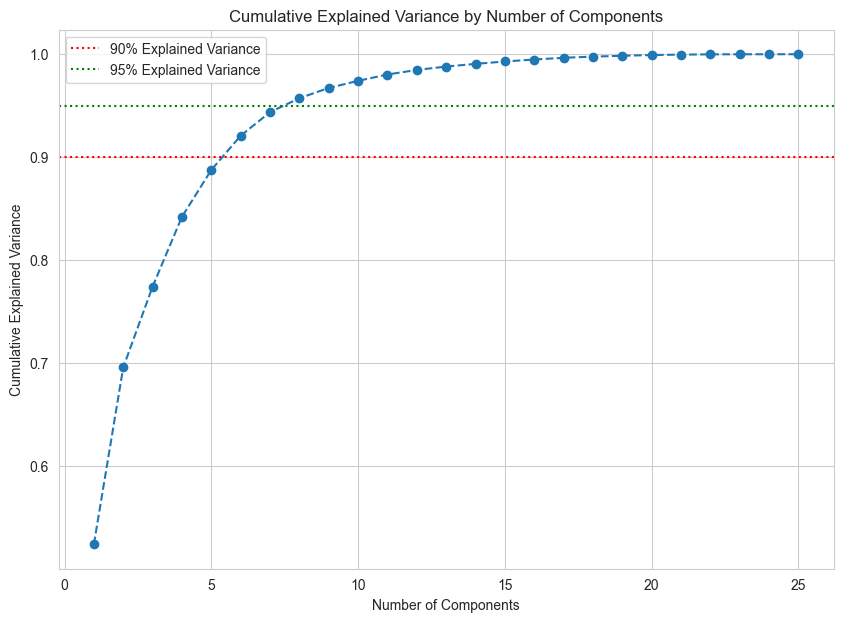

In [8]:
# Determine optimal number of components
pca_full = PCA().fit(X_processed)
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         np.cumsum(pca_full.explained_variance_ratio_), 
         marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle=':', label='90% Explained Variance')
plt.axhline(y=0.95, color='g', linestyle=':', label='95% Explained Variance')
plt.legend()
plt.show()


In [9]:
# Apply PCA with 8 components to capture >95% of variance
pca = PCA(n_components=8)
X_pca_array = pca.fit_transform(X_processed)
pca_columns = [f'PC_{i+1}' for i in range(X_pca_array.shape[1])]
X_pca = pd.DataFrame(X_pca_array, columns=pca_columns)

print("Shape of PCA features (X_pca):", X_pca.shape)
X_pca.head()


Shape of PCA features (X_pca): (569, 8)


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8
0,8.946749,1.852262,-1.563784,-3.438589,-0.108590,1.496785,2.199281,0.016557
1,2.639545,-3.237510,0.359047,-1.021212,-1.406270,0.419406,-0.136762,0.071288
2,5.805889,-0.432799,-0.081577,-0.822497,-0.194291,0.401335,-0.711349,-0.339058
3,6.200305,9.388259,1.757786,-1.858911,0.966181,1.587664,1.512284,-0.345976
4,4.015827,-2.248372,-2.216997,-1.481469,-1.048437,-0.594708,-0.518557,0.324624


## 3. Technique 2: Ratio Features (Shape Metrics)

Now, let's create features based on domain knowledge. We'll calculate ratios that represent tumor shape and growth as we know that these are features that can be used to predict the diagnosis. These must be calculated on the **unscaled** data to preserve their physical meaning. Afterwards, we will scale the complete dataset.


In [10]:
# Use the unscaled data with selected features
X_with_ratios_unscaled = X_selected_unscaled.copy()

# Create shape factor
# Using original feature names from before selection
X_with_ratios_unscaled['shape_factor'] = X_unscaled['perimeter_mean']**2 / X_unscaled['area_mean']

# Create growth factor
X_with_ratios_unscaled['radius_growth'] = X_unscaled['radius_worst'] / X_unscaled['radius_mean']

# Scale the entire new feature set
scaler_ratios = StandardScaler()
X_ratios_scaled_array = scaler_ratios.fit_transform(X_with_ratios_unscaled)
X_with_ratios = pd.DataFrame(X_ratios_scaled_array, columns=X_with_ratios_unscaled.columns)

print("Shape of features with ratios (X_with_ratios):", X_with_ratios.shape)
X_with_ratios.head()


Shape of features with ratios (X_with_ratios): (569, 27)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,radius_se,perimeter_se,area_se,compactness_se,concavity_se,concave points_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,shape_factor,radius_growth
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.489734,2.833031,2.487578,1.316862,0.724026,0.660820,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,2.417255,3.310149
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,0.499255,0.263327,0.742402,-0.692926,-0.440780,0.260162,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,-0.630630,0.897126
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,1.228676,0.850928,1.181336,0.814974,0.213076,1.424827,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,0.641389,0.677613
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,0.326373,0.286593,-0.288378,2.744280,0.819518,1.115007,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,3.331880,2.014637
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,1.270543,1.273189,1.190357,-0.048520,0.828471,1.144205,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,0.683787,-0.383659


## 4. Technique 3: Polynomial Features

This technique automatically creates interaction terms and higher-order features. To avoid creating too many features (the "curse of dimensionality"), we will only apply this to the top 5 most predictive features identified in our EDA.


In [11]:
# Top 5 features from EDA
top_features = [
    'concave points_worst', 
    'perimeter_worst', 
    'concave points_mean',
    'radius_worst', 
    'perimeter_mean'
]

# Initialize PolynomialFeature, degree=2 will create interaction terms (a*b) and quadratic terms (a^2)
# include_bias=False prevents adding a constant column of ones
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform the top features from the SCALED data
poly_features = poly.fit_transform(X_processed[top_features])

# Create a DataFrame with the new polynomial feature names
poly_feature_names = poly.get_feature_names_out(top_features)
X_poly_generated = pd.DataFrame(poly_features, columns=poly_feature_names)

# Drop the original top 5 features from our main processed set to avoid duplication
X_processed_without_top5 = X_processed.drop(columns=top_features)

# Concatenate the two dataframes
X_poly = pd.concat([X_processed_without_top5.reset_index(drop=True), X_poly_generated.reset_index(drop=True)], axis=1)

print("Shape of polynomial features (X_poly):", X_poly.shape)
X_poly.head()


Shape of polynomial features (X_poly): (569, 40)


,radius_mean,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,radius_se,perimeter_se,area_se,compactness_se,concavity_se,concave points_se,texture_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,concave points_worst,perimeter_worst,concave points_mean,radius_worst,perimeter_mean,concave points_worst^2,concave points_worst perimeter_worst,concave points_worst concave points_mean,concave points_worst radius_worst,concave points_worst perimeter_mean,perimeter_worst^2,perimeter_worst concave points_mean,perimeter_worst radius_worst,perimeter_worst perimeter_mean,concave points_mean^2,concave points_mean radius_worst,concave points_mean perimeter_mean,radius_worst^2,radius_worst perimeter_mean,perimeter_mean^2
0,1.097064,-2.073335,0.984375,1.568466,3.283515,2.652874,2.217515,2.489734,2.833031,2.487578,1.316862,0.724026,0.660820,-1.359293,2.001237,1.307686,2.616665,2.109526,2.750622,1.937015,2.296076,2.303601,2.532475,1.886690,1.269934,5.271966,5.289242,5.814756,4.331983,2.915864,5.306576,5.833811,4.346179,2.925420,6.413431,4.777995,3.216076,3.559598,2.395971,1.612732
1,1.829821,-0.353632,1.908708,-0.826962,-0.487072,-0.023846,0.001392,0.499255,0.263327,0.742402,-0.692926,-0.440780,0.260162,-0.369203,1.890489,-0.375612,-0.430444,-0.146749,-0.243890,0.281190,1.087084,1.535126,0.548144,1.805927,1.685955,1.181752,1.668811,0.595879,1.963195,1.832775,2.356612,0.841470,2.772326,2.588153,0.300462,0.989909,0.924146,3.261374,3.044712,2.842443
2,1.579888,0.456187,1.558884,0.942210,1.052926,1.363478,0.939685,1.228676,0.850928,1.181336,0.814974,0.213076,1.424827,-0.023974,1.456285,0.527407,1.082932,0.854974,1.152255,0.201391,1.955000,1.347475,2.037231,1.511870,1.566503,3.822026,2.634315,3.982787,2.955707,3.062514,1.815689,2.745118,2.037208,2.110824,4.150309,3.080029,3.191328,2.285752,2.368349,2.453932
3,-0.768909,0.253732,-0.764464,3.283553,3.402909,1.915897,2.867383,0.326373,0.286593,-0.288378,2.744280,0.819518,1.115007,0.133984,-0.550021,3.394275,3.893397,1.989588,6.046041,4.935010,2.175786,-0.249939,1.451707,-0.281464,-0.592687,4.734045,-0.543814,3.158605,-0.612406,-1.289560,0.062470,-0.362839,0.070349,0.148136,2.107454,-0.408604,-0.860408,0.079222,0.166820,0.351278
4,1.750297,-1.151816,1.826229,0.280372,0.539340,1.371011,-0.009560,1.270543,1.273189,1.190357,-0.048520,0.828471,1.144205,-1.466770,1.220724,0.220556,-0.313395,0.613179,-0.868353,-0.397100,0.729259,1.338539,1.428493,1.298575,1.776573,0.531819,0.976142,1.041742,0.946998,1.295582,1.791688,1.912094,1.738194,2.378013,2.040592,1.855005,2.537822,1.686298,2.307014,3.156212


As we can see, a lot of new features are created, but we can see that the number of features is still manageable. This added complexity will be useful to capture non-linear relationships in the data, but we need to be careful not to overfit the model.

## 5. Next steps

We have engineered several new feature sets, giving us multiple candidates for our modeling stage.

**Generated Feature Sets:**
1.  **`X_processed`**: Baseline cleaned and scaled features (25 features).
2.  **`X_pca`**: PCA-transformed features (8 features).
3.  **`X_with_ratios`**: Baseline features plus our new shape and growth metrics, all scaled (27 features).
4.  **`X_poly`**: Baseline features with the top 5 replaced by their polynomial/interaction terms (40 features).

**Next Notebook:** `4.0-Model_Experimentation.ipynb`. In this next step, we will train and evaluate various classification models on all four of these feature sets to find the combination that yields the best performance.
